# Problem Set 3: CSS 100

In this lab, you'll get hands-on practice understanding **classification techniques**.

This will include:

- Understanding the math behind **decision trees**.
- Evaluating different **classifier** approaches.  

In [20]:
### Make sure to run this code!
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt

In [21]:
# Make sure to run this code!
df_ads = pd.read_csv("data/Social_Network_Ads.csv")
df_ads.head(3)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0


## Part 1: Understanding decision trees

In this section of the problem set, you'll implement (and interpret) some of the basic math behind decision trees, such as `entropy` and `information gain`.

### Q1. Implement a `calculate_entropy` function

Write a function called `calculate_entropy` which takes as input a `numpy.array` of probability values, and calculates the **entropy** of that distribution.

Recall that entropy is defined as follows:

$$Entropy =-\sum _{k = 1}^K p(x_k)\log p(x_k)$$

A few notes:

- You'll want to ignore any *zeroes* in the distribution
- Use `numpy.log2` as the log base.

In [22]:
### BEGIN SOLUTION
def calculate_entropy(probabilities):
    """
    Calculate the entropy of a probability distribution.

    Args:
    probabilities: A numpy array of probabilities.

    Returns:
    The entropy of the probability distribution.
    """
    # Filter out zero probabilities to avoid log(0) warnings
    non_zero_probs = probabilities[probabilities != 0]
    
    # Calculate entropy
    entropy_value = -np.sum(non_zero_probs * np.log2(non_zero_probs))
    return entropy_value
### END SOLUTION

In [23]:
assert calculate_entropy

p_original = np.array([.5, .5])
p_new1 = np.array([.75, .25])
p_new2 = np.array([.25, .75])

assert calculate_entropy(p_original) == 1
assert round(calculate_entropy(p_new1), 2) == 0.81
assert round(calculate_entropy(p_new2), 2) == 0.81

### Q2. Implement a `calculate_information_gain` function

Write a function called `calculate_information_gain`, which:

- Takes as input:
   - `P_original`: the original probability distribution. 
   - `P_new1`: one of the new splits. 
   - `P_new2`: the other of the new splits. 
   - `D`: the size of the original dataset.  
   - `D1`: the size of the first split. 
   - `D2`: the size of the second split. 
- Calculates the relative *information gain* between `P_original` and both `P_new_1` and `P_new_2`, weighted by their size `D1` and `D1` respectively.

Recall that $IG$ in this case is defined as:

$IG = Entropy(P_{original}) - (\frac{|D_1|}{|D|} * Entropy(P_{new1}) + \frac{|D_2|}{|D|} * Entropy(P_{new2}))$

And $|D_1|$ and $D_2$ is the size of the split in question.

In [24]:
### BEGIN SOLUTION
def calculate_information_gain(P_original, P_new1, P_new2, D, D1, D2):
    """
    Calculate the relative information gain between P_original and both P_new1 and P_new2,
    weighted by their size D1 and D2 respectively.

    Args:
    P_original: The original probability distribution.
    P_new1: The probability distribution of the first split.
    P_new2: The probability distribution of the second split.
    D: The size of the original dataset.
    D1: The size of the first split.
    D2: The size of the second split.

    Returns:
    The relative information gain between P_original and both P_new1 and P_new2.
    """
    # Calculate entropy of original distribution
    entropy_original = calculate_entropy(P_original)

    # Calculate entropy of each split
    entropy_new1 = calculate_entropy(P_new1)
    entropy_new2 = calculate_entropy(P_new2)

    # Calculate weighted average of entropies of splits
    weighted_entropy_splits = (D1/D) * entropy_new1 + (D2/D) * entropy_new2

    # Calculate relative information gain
    information_gain = entropy_original - weighted_entropy_splits

    return information_gain
### END SOLUTION

In [25]:
### At least one hidden test
assert calculate_information_gain

## Set up for first test
p_original = np.array([.5, .5])
p_new1 = np.array([.75, .25])
p_new2 = np.array([.25, .75])
D = 100
D1 = 50
D2 = 50

assert round(calculate_information_gain(p_original, p_new1, p_new2, 100, D1, D2), 2) == 0.19

### BEGIN HIDDEN TESTS
p_original = np.array([.5, .5])
p_new1 = np.array([.8, .2])
p_new2 = np.array([.2, .8])
D = 100
D1 = 50
D2 = 50
assert round(calculate_information_gain(p_original, p_new1, p_new2, 100, D1, D2), 2) == 0.28
### END HIDDEN TESTS

### Q3. Implement a `try_splits` function

Now, write a function called `try_splits` that will take as input:

- `X`: a feature. 
- `Y`: an array of response values (e.g., `1` vs. `0`). 

This function should try out various *splits* of $X$. For each unique value of $X$, the function should calculate the **information gain** between the original `entropy` of $Y$ and the new splits. The function should `return` a `DataFrame` with a column for `split_location` (where the split was done on $X$) and `information_gain` (the information gain of that split). 

**Hints**:

1. You'll first want to get the unique values of `X` using `set`.  
2. For each unique value of `X`, try splitting `Y`.  
3. Then, you'll compare the information gain for each of these splits to the original distribution $Y$ using `calculate_information_gain`.

You can implement steps 2-3 in a few ways, but this is what I did for part of the problem:

```python
Y_left = Y[X <= split]
P_left = np.array([(Y_left == val).mean() for val in set(Y)])
```

Where `split` is some value of `X`.

**Note**: You'll probably also want to skip splits where either of the splits results in a split of size 0, e.g.,:

```python
if len(Y_left) == 0 or len(Y_right) == 0:
    continue  # Skip this split if either side is empty

```

In [31]:
### BEGIN SOLUTION
def try_splits(X, Y):
    """
    Try out various splits of X. For each split, calculate the information gain
    between the original entropy of Y and the new splits.

    Args:
    X: A feature.
    Y: An array of response values.

    Returns:
    A DataFrame with columns for split and information_gain.
    """
    result = []
    
    # Sort the feature values
    unique_values = sorted(set(X))
    
    # Iterate over each unique value as a potential split point
    for split in unique_values:
        # split = (unique_values[i - 1] + unique_values[i]) / 2.0
                
        # Split the data based on the current split point
        Y_left = Y[X <= split]
        Y_right = Y[X > split]
        
        if len(Y_left) == 0 or len(Y_right) == 0:
            continue  # Skip this split if either side is empty
        
        # Calculate probabilities for original and split datasets
        P_original = np.array([(Y == val).mean() for val in set(Y)])
        P_left = np.array([(Y_left == val).mean() for val in set(Y)])
        P_right = np.array([(Y_right == val).mean() for val in set(Y)])
        
        # Calculate sizes of datasets
        D = len(Y)
        D_left = len(Y_left)
        D_right = len(Y_right)
        
        # Calculate information gain for the current split
        information_gain = calculate_information_gain(P_original, P_left, P_right, D, D_left, D_right)
        
        # Append the result to the list
        result.append({'split': split, 'information_gain': information_gain})
    
    # Convert the result list to a DataFrame
    result_df = pd.DataFrame(result)
    
    return result_df
### END SOLUTION

In [32]:
assert try_splits

results_df = try_splits(df_ads['EstimatedSalary'].values, df_ads['Purchased'].values)
assert "split" in results_df.columns
assert "information_gain" in results_df.columns

In [33]:
### Contains at least one hidden test
assert round(results_df['information_gain'].max(), 2) > 0.2
assert results_df['split'][results_df['information_gain'].argmax()] == 89000

### Q4. Visualize `information_gain`

Now, create a `lineplot` showing the relationship between `split` and `information_gain`. Is there a clear value of $X$ that maximizes information gain?

Text(0, 0.5, 'Information Gain')

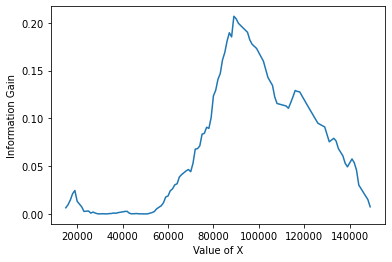

In [34]:
### BEGIN SOLUTION
sns.lineplot(data = results_df, x = "split", y = "information_gain")
plt.xlabel("Value of X")
plt.ylabel("Information Gain")
### END SOLUTION

## Part 2: Using decision trees in Python

Now that you've gotten a sense of how the **splitting** process works, we can move on to using `sklearn`. This will allow us to compare different kinds of **tree-based classification methods**.

In [35]:
### Run this code!
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Q5. Create a `train_test_split`

In this problem, use the `train_test_split` function to *split* your data. First:

- Create your features $X$, using `EstimatedSalary` and `Age`.  
- Create your response $Y$, using `Purchased`.  
- Then, create train/test versions of each using `train_test_split`, with a random state of `42` and a `test_size` of `.33`. Call these `X_train, X_test, y_train, y_test`.

Set `random_state = 42`

In [36]:
### BEGIN SOLUTION
X = df_ads[['EstimatedSalary', 'Age']].values
y = df_ads['Purchased'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
### END SOLUTION

In [37]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

### Q6. Fit a `DecisionTreeClassifier`

Now, fit a `DecisionTreeClassifier` to your training set, and generate predictions for your test set. Calculate the accuracy of your test set and call it `dt_test_acc`.

For `DecisionTreeClassifier`, use the default parameters, except set `random_state = 42`.

In [38]:
### BEGIN SOLUTION
clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

df_test_acc = accuracy_score(y_test, y_pred)
### END SOLUTION

In [39]:
assert df_test_acc
assert round(df_test_acc, 2) == 0.86

### Q7. Fit a `RandomForestClassifier`

Now, fit a `RandomForestClassifier` to your training set, and generate predictions for your test set. Calculate the accuracy of your test set and call it `rf_test_acc`.

For `RandomForestClassifier`, use the default parameters, except set `random_state = 42`.

In [40]:
### BEGIN SOLUTION
clf = RandomForestClassifier(random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

rf_test_acc = accuracy_score(y_test, y_pred)
### END SOLUTION

In [41]:
assert rf_test_acc
assert round(rf_test_acc, 2) == 0.90

### Q8. Fit a `BaggingClassifier`

Now, fit a `BaggingClassifier` to your training set, and generate predictions for your test set. Calculate the accuracy of your test set and call it `bc_test_acc`.

For `BaggingClassifier`, use the default parameters, except set `random_state = 42`.

In [18]:
### BEGIN SOLUTION
clf = BaggingClassifier(random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

bc_test_acc = accuracy_score(y_test, y_pred)
### END SOLUTION

In [19]:
assert bc_test_acc
assert round(bc_test_acc, 2) == 0.89

## Submit!

Congratulations! You've now gotten some practice fitting various tree-based classifiers, and using them to predict data. Don't forget to click validate and submit.